<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#modeling" data-toc-modified-id="modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>modeling</a></span></li></ul></div>

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))

In [2]:
from load_data import LoadData
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from nklearn.lgbm_util.modeling import CvEnsembleModeling
import numpy as np
import pandas as pd
import uuid

In [3]:
uid = uuid.uuid1()

In [4]:
alg = "lgb"

In [5]:
docs = "../docs/"
finfo = docs + "info/" + "ddl.csv"

data = "../data/"
data_in, data_mid, data_out = [data + fld for fld in ["in/", "mid/", "out/"]]

fin, ftest = data_in + "train_data.csv", data_in + "test_data.csv"
fmid = data_mid + "%s_%s.csv"%(alg, uid)
fout = data_out + "%s_%s.csv"%(alg, uid)

models = "../models/"
mout = models + "%s_%s.pkl"%(alg, uid)

loader = LoadData(fin, ftest, finfo)

In [6]:
X, y, test_X = loader.get_features_v1()

In [7]:
y = y.astype(float)

# modeling

In [8]:
opt = CvEnsembleModeling()

In [9]:
models, best_scores = opt.opt_fit(X=X, y=y, n_trials=20)

[I 2019-04-14 15:11:19,285] Finished trial#0 resulted in value: 0.24561410647219506. Current best value is 0.24561410647219506 with parameters: {'num_leaves': 481, 'learning_rate': 0.20283955241701276, 'feature_fraction': 0.3870762819285266}.
[I 2019-04-14 15:11:19,641] Finished trial#1 resulted in value: 0.2270117212543057. Current best value is 0.2270117212543057 with parameters: {'num_leaves': 72, 'learning_rate': 1.0216570061307609e-05, 'feature_fraction': 0.38235154108827485}.
[I 2019-04-14 15:11:20,079] Finished trial#2 resulted in value: 0.2198307807672505. Current best value is 0.2198307807672505 with parameters: {'num_leaves': 116, 'learning_rate': 5.34398624512123e-05, 'feature_fraction': 0.7553879012148553}.
[I 2019-04-14 15:11:20,427] Finished trial#3 resulted in value: 0.22315180943662793. Current best value is 0.2198307807672505 with parameters: {'num_leaves': 116, 'learning_rate': 5.34398624512123e-05, 'feature_fraction': 0.7553879012148553}.
[I 2019-04-14 15:11:20,833] 

[I 2019-04-14 15:11:37,822] Finished trial#13 resulted in value: 0.21064963483216892. Current best value is 0.21064963483216892 with parameters: {'num_leaves': 110, 'learning_rate': 0.008028706425629976, 'feature_fraction': 0.6647864421986172}.
[I 2019-04-14 15:11:38,341] Finished trial#14 resulted in value: 0.21114625990594804. Current best value is 0.21064963483216892 with parameters: {'num_leaves': 110, 'learning_rate': 0.008028706425629976, 'feature_fraction': 0.6647864421986172}.
[I 2019-04-14 15:11:38,833] Finished trial#15 resulted in value: 0.2101168771325942. Current best value is 0.2101168771325942 with parameters: {'num_leaves': 131, 'learning_rate': 0.0012489279279280477, 'feature_fraction': 0.6568682641928606}.
[I 2019-04-14 15:11:39,249] Finished trial#16 resulted in value: 0.23248783650741256. Current best value is 0.2101168771325942 with parameters: {'num_leaves': 131, 'learning_rate': 0.0012489279279280477, 'feature_fraction': 0.6568682641928606}.
[I 2019-04-14 15:11:4

[I 2019-04-14 15:11:57,917] Finished trial#6 resulted in value: 0.2534380094179094. Current best value is 0.221529724345786 with parameters: {'num_leaves': 158, 'learning_rate': 1.8926638609312714e-05, 'feature_fraction': 0.7000674284135379}.
[I 2019-04-14 15:11:59,326] Finished trial#7 resulted in value: 0.2198754655301698. Current best value is 0.2198754655301698 with parameters: {'num_leaves': 365, 'learning_rate': 0.004948894693502531, 'feature_fraction': 0.35220158481258623}.
[I 2019-04-14 15:11:59,766] Finished trial#8 resulted in value: 0.24581462096776285. Current best value is 0.2198754655301698 with parameters: {'num_leaves': 365, 'learning_rate': 0.004948894693502531, 'feature_fraction': 0.35220158481258623}.
[I 2019-04-14 15:12:00,092] Finished trial#9 resulted in value: 0.2411704866330131. Current best value is 0.2198754655301698 with parameters: {'num_leaves': 365, 'learning_rate': 0.004948894693502531, 'feature_fraction': 0.35220158481258623}.
[I 2019-04-14 15:12:00,841]

[I 2019-04-14 15:12:18,180] Finished trial#19 resulted in value: 0.2364547514126336. Current best value is 0.22111606704660103 with parameters: {'num_leaves': 62, 'learning_rate': 0.0007118894753684304, 'feature_fraction': 0.8545824220151033}.


In [10]:
w = 1 - np.array(best_scores)

In [11]:
def predict(X, models, weight):
    preds = []
    X = np.array(X)
    for model, w in zip(models, weight):
        preds.append(model.predict(X)*w)
    preds = np.array(preds)
    return preds.sum(0)/sum(weight)


In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
p = predict(X, models, w)

In [14]:
roc_auc_score(y_true=y, y_score=p)

0.8741774757397277

In [15]:
best_thre, max_acc = 0,0
for thre in range(100):
    b = p >= thre/100
    b = np.vectorize(int)(b)
    acc = sum(b == y)/len(y)
    if acc > max_acc:
        best_thre = thre/100
        max_acc = acc
    print(thre, acc)

0 0.222
1 0.222
2 0.222
3 0.222
4 0.222
5 0.222
6 0.222
7 0.222
8 0.222
9 0.222
10 0.222
11 0.222
12 0.222
13 0.222
14 0.222
15 0.222
16 0.222
17 0.222
18 0.222
19 0.222
20 0.222
21 0.222
22 0.7697037037037037
23 0.840925925925926
24 0.8387407407407408
25 0.801962962962963
26 0.7788148148148148
27 0.778
28 0.778
29 0.778
30 0.778
31 0.778
32 0.778
33 0.778
34 0.778
35 0.778
36 0.778
37 0.778
38 0.778
39 0.778
40 0.778
41 0.778
42 0.778
43 0.778
44 0.778
45 0.778
46 0.778
47 0.778
48 0.778
49 0.778
50 0.778
51 0.778
52 0.778
53 0.778
54 0.778
55 0.778
56 0.778
57 0.778
58 0.778
59 0.778
60 0.778
61 0.778
62 0.778
63 0.778
64 0.778
65 0.778
66 0.778
67 0.778
68 0.778
69 0.778
70 0.778
71 0.778
72 0.778
73 0.778
74 0.778
75 0.778
76 0.778
77 0.778
78 0.778
79 0.778
80 0.778
81 0.778
82 0.778
83 0.778
84 0.778
85 0.778
86 0.778
87 0.778
88 0.778
89 0.778
90 0.778
91 0.778
92 0.778
93 0.778
94 0.778
95 0.778
96 0.778
97 0.778
98 0.778
99 0.778


In [16]:
p = predict(test_X, models, w)

In [17]:
b = p >= best_thre
Y = np.vectorize(int)(b)

In [18]:
test_X["Y"] = Y

In [19]:
test_X["ID"] = test_X.index

In [20]:
test_X[["ID", "Y"]].to_csv(fout, index=False)

In [21]:
joblib.dump(models, mout)

['../models/lgb_0f23c9cc-5e7c-11e9-aca4-f06e0bb794dc.pkl']

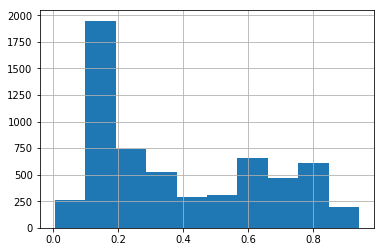

In [34]:
X[y==1][fmid].hist()

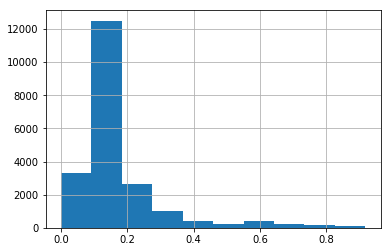

In [35]:
X[y==0][fmid].hist()